# Parameter Ensemble
## Goal: sample parameter uncertainty using an ensemble within probable ranges
- Parameters in FaIR are termed "configs" (climate and species configs)

### Erica Simon, 01/23/24
This notebook is adapted from the following example: https://github.com/OMS-NetZero/FAIR/blob/master/docs/examples/calibrated_constrained_ensemble.rst

## Imports

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Create instance

In [108]:
f = FAIR()

## Define time horizon

In [109]:
f.define_time(1850, 2100, 1)

## Define scenarios

We will use 3 scenarios from the SSPs that span low, medium, and high radiative forcing outcomes.

In [110]:
scenarios = ['ssp119', 'ssp370', 'ssp585']
f.define_scenarios(scenarios)

## Define configs

We retrieve the parameter ensemble from Dr. Smith's Zenodo.

This is the currently the most recent dataset (as of Jan 2024), but check this link to see if a new version has been posted: https://zenodo.org/records/10208609

In [111]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/10208609/files/calibrated_constrained_parameters.csv',
    known_hash = 'a8534618e5ee10b290e566747164a46784830ec55626cca5413eff9a02fc1c32'
)

In [112]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [113]:
df_configs.head()

,clim_gamma,clim_c1,clim_c2,clim_c3,clim_kappa1,clim_kappa2,clim_kappa3,clim_epsilon,clim_sigma_eta,clim_sigma_xi,...,fscale_Stratospheric water vapour,fscale_Land use,fscale_Volcanic,fscale_solar_amplitude,fscale_solar_trend,fscale_Light absorbing particles on snow and ice,fscale_Contrails,fscale_CO2,cc_co2_concentration_1750,seed
394,5.196186,3.209179,26.504324,74.936014,1.045542,2.487784,1.063708,1.231824,1.274014,0.575318,...,2.393013,1.537615,0.841857,0.866718,-0.023048,1.438652,2.110481,0.829897,276.973516,1512969
1850,2.288617,3.895453,21.631605,71.006254,1.114593,2.723680,0.810501,1.451213,0.383414,0.395347,...,2.067132,0.934253,1.099843,1.083101,-0.039804,1.827225,0.982702,0.905741,277.521081,2093913
1923,5.628552,3.201160,30.358740,69.274958,1.963336,3.091190,0.547595,1.226456,0.825602,0.307442,...,0.569276,1.006613,1.028865,1.200466,-0.029519,0.939350,-0.011421,0.879706,274.048094,2123040
2317,18.468801,3.163827,22.835474,121.188981,0.948618,4.202631,1.376017,1.239907,0.959614,0.644744,...,0.726182,1.199499,0.952418,0.983109,-0.045739,0.075185,0.250826,1.091131,277.121190,2280246
2516,2.975201,5.319507,11.528340,105.104136,1.481714,1.045909,2.086986,1.826375,1.129155,0.512410,...,0.299357,0.889282,0.832298,1.123303,-0.052782,1.157428,0.924670,0.996611,279.909930,2359647


## Define species and properties

Fill species and properties from csv file. There are 63 species, which all act as forcing agents.

In [114]:
species, properties = read_properties(filename='~/data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

## Create input & output arrays

In [115]:
f.allocate()

## Fill data

### Emissions and forcings

Since we defined our scenarios as SSPs, we can use the built in 'fill_from_rcmip' function to populate the emisisons xarray.

Note: RCMIP = Reduced Complexity Model Intercomparison Project

In [116]:
f.fill_from_rcmip()

Next, we will fill in solar and volcanic forcings

In [117]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [118]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [119]:
# retreive data
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col='timebounds')

In [120]:
# populate data for relevant years into numpy array
solar_forcing = np.zeros(251)
volcanic_forcing = np.zeros(251)

solar_forcing = df_solar["erf"].loc[1850:2100].values
volcanic_forcing = df_volcanic["erf"].loc[1850:2100].values

trend_shape = np.ones(251)
trend_shape[:251] = np.linspace(0, 1, 251)

The parameter ensemble is used to scale the volcanic and solar timeseries

In [121]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

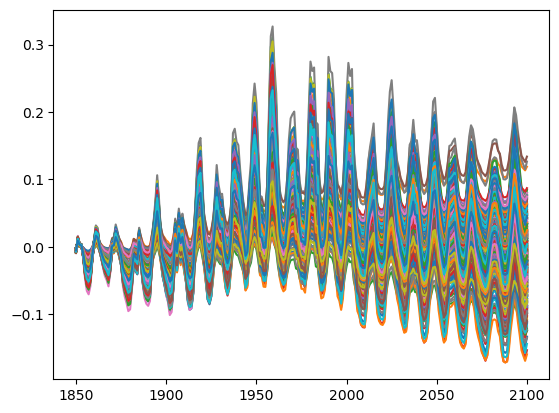

In [122]:
plt.plot(f.timebounds, f.forcing.loc[dict(specie="Solar", scenario="ssp370")]);

#### Adjustments
The content below is taken directly from https://github.com/OMS-NetZero/FAIR/blob/master/docs/examples/calibrated_constrained_ensemble.rst 

This is only required if the 'fill_from_rcmip' function is used to fill the emissions xarray.

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:

- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [127]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)

df_emis = pd.read_csv(rcmip_emissions_file)

In [128]:
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]

for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1850":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:250, None]

### Climate configs

Simply fill from 'calibrated_constrained' dataset

In [129]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### Species configs

In [132]:
# get updated defaults
f.fill_species_configs(filename='~/data/species_configs_properties_calibration1.2.0.csv')

### Initial conditions

## Run

## Analyze output